## Introduction

In this project, we explore candidate characteristics and endorsements in the 2022 U.S. primary elections.  
Our research is guided by two questions:

- **RQ1:** Which candidate characteristics are associated with higher vote share in primary elections?  
- **RQ2:** Does having at least one endorsement increase a candidate’s primary vote percentage?  

Primary elections are particularly interesting because candidates compete within their own party, often making factors like visibility, resources, and endorsements especially impactful. Our goal is to use a combination of statistical hypothesis testing and causal inference to better understand these dynamics.  

---
## Data Cleaning & Feature Engineering

We worked with datasets of Democratic and Republican candidates containing demographics, endorsements, and outcomes.  
Key preprocessing steps included:

- Converting vote share (e.g., `"45%"`) into numeric values.  
- Handling missing data: `"N/A"` in endorsements treated as no action, race simplified to primary category.  
- Creating binary indicators (e.g., endorsed = 1, not endorsed = 0).  
- One-hot encoding categorical features where needed.  

These steps ensured the dataset was ready for both statistical tests and causal inference models.  

---

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample


In [138]:
dem_df = pd.read_csv('dataset/dem_candidates.csv')
rep_df = pd.read_csv('dataset/rep_candidates.csv')

In [139]:
dem_df['Party'] = 'Democrat'
rep_df['Party'] = 'Republican'
df = pd.concat([dem_df, rep_df], ignore_index=True)
df.columns = df.columns.str.strip().str.replace(" ", "_")

In [140]:
endorsements = ['EMILY\'s_List', 'Justice_Dems', 'Indivisible', 'PCCC', 'Our_Revolution', 'Sunrise', 'Sanders', 
  'AOC', 'Party_Committee', 'Trump', 'Club_for_Growth', 'Party_Committee',
     'Renew_America', 'E-PAC', 'VIEW_PAC', 'Maggie\'s_List', 'Winning_for_Women']

In [141]:
df.columns

Index(['Candidate', 'Gender', 'Race_1', 'Race_2', 'Race_3', 'Incumbent',
       'Incumbent_Challenger', 'State', 'Primary_Date', 'Office', 'District',
       'Primary_Votes', 'Primary_%', 'Primary_Outcome', 'Runoff_Votes',
       'Runoff_%', 'Runoff_Outcome', 'EMILY's_List', 'Justice_Dems',
       'Indivisible', 'PCCC', 'Our_Revolution', 'Sunrise', 'Sanders', 'AOC',
       'Party_Committee', 'Party', '2020_Election_Stance', 'Trump',
       'Trump_Date', 'Club_for_Growth', 'Renew_America', 'E-PAC', 'VIEW_PAC',
       'Maggie's_List', 'Winning_for_Women'],
      dtype='object')

In [142]:
df['Sanders_Endorsed'] = df['Sanders'].notna()

In [143]:
mapping = {
    "Yes": 1,
    "Yes ": 1, 
    "Yes (runoff only)": 1,
    "No": 0,
    "No (runoff only)": 0
}

In [144]:
for endorsement in endorsements:
    df[endorsement] = df[endorsement].replace(mapping)
    df[endorsement] = df[endorsement].fillna(0)
    df[endorsement] = df[endorsement].astype(int)

/var/folders/8_/8p8vwl993bl8zs1xrcs95xlw0000gn/T/ipykernel_12030/4041712178.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[endorsement] = df[endorsement].replace(mapping)
/var/folders/8_/8p8vwl993bl8zs1xrcs95xlw0000gn/T/ipykernel_12030/4041712178.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[endorsement] = df[endorsement].replace(mapping)
/var/folders/8_/8p8vwl993bl8zs1xrcs95xlw0000gn/T/ipykernel_12030/4041712178.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future v

In [145]:
for endorsement in endorsements:
    print(df[endorsement].unique().tolist())

[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[0, 1]


In [146]:
# vote share and convert % strings to float
df['Primary_%'] = df['Primary_%'].str.rstrip('%').replace('N/A', pd.NA).astype(float)
df['Runoff_%'] = df['Runoff_%'].str.rstrip('%').replace('N/A', pd.NA).astype(float)
# vote counts to numeric
df['Primary_Votes'] = pd.to_numeric(df['Primary_Votes'], errors='coerce')
df['Runoff_Votes'] = pd.to_numeric(df['Runoff_Votes'], errors='coerce')

# binary variables for hypothesis testing
df["EMILYs_List_Endorsed"] = df["EMILY's_List"].notna()
df['Party_bin'] = df['Party'].map({'dem': 0, 'rep': 1})
df['incum_bin'] = df['Incumbent'].map({'Yes': 1, 'No': 0})
df['Incumbent'] = df['Incumbent'] == 'Yes'
df['Woman'] = df['Gender'] == 'Female'
df['Party'] = df['Party'].fillna('Unknown')

In [147]:
df['Sanders_Endorsed']

0       False
1       False
2       False
3       False
4       False
        ...  
2671    False
2672    False
2673    False
2674    False
2675    False
Name: Sanders_Endorsed, Length: 2676, dtype: bool

In [148]:
df['num_endorsements'] = df[endorsements].sum(axis=1)

In [149]:
temp2 = df['num_endorsements']

In [150]:
df['treated'] = df['num_endorsements'] > 0
df['treated'] = df['treated'].astype(int)

In [151]:
df['incum_bin'].unique()

array([0, 1])

In [152]:
temp = df['Race_1']

In [153]:
def has_oppose(endorsements):
    if endorsements == 0:
        return True
    else:
        return False

for endorsement in endorsements:
    df['Opposed'] = df[endorsement].apply(has_oppose)



# Binary values for Opposed column
df['Opposed_bin'] = df['Opposed'].map({True: 1, False: 0})
# Fill NaN values of Total_Receipt to 0
df['Party_bin'] = df['Party'].map({'Democrat': 0, 'Republican': 1})

# Clean up Race 1 to just be the main race
df['Race_1'] = df['Race_1'].str.extract(r'^([A-Za-z]+)', expand=False)

# Clean up Office to just be the main office
df['Office'] = df['Office'].str.extract(r'^([A-Za-z]+)', expand=False)

# One hot encoding of Races
df = pd.get_dummies(df, columns=['Race_1'], drop_first=False)

# One hot encoding of Office
df = pd.get_dummies(df, columns=['Office'], drop_first=False)

In [154]:
df['Race_1'] = temp

In [155]:
df['num_endorsements'] = temp2

In [156]:
df.columns

Index(['Candidate', 'Gender', 'Race_2', 'Race_3', 'Incumbent',
       'Incumbent_Challenger', 'State', 'Primary_Date', 'District',
       'Primary_Votes', 'Primary_%', 'Primary_Outcome', 'Runoff_Votes',
       'Runoff_%', 'Runoff_Outcome', 'EMILY's_List', 'Justice_Dems',
       'Indivisible', 'PCCC', 'Our_Revolution', 'Sunrise', 'Sanders', 'AOC',
       'Party_Committee', 'Party', '2020_Election_Stance', 'Trump',
       'Trump_Date', 'Club_for_Growth', 'Renew_America', 'E-PAC', 'VIEW_PAC',
       'Maggie's_List', 'Winning_for_Women', 'Sanders_Endorsed',
       'EMILYs_List_Endorsed', 'Party_bin', 'incum_bin', 'Woman',
       'num_endorsements', 'treated', 'Opposed', 'Opposed_bin', 'Race_1_Asian',
       'Race_1_Black', 'Race_1_Latino', 'Race_1_Middle', 'Race_1_Native',
       'Race_1_Pacific', 'Race_1_Unknown', 'Race_1_White', 'Office_Governor',
       'Office_Representative', 'Office_Senator', 'Race_1'],
      dtype='object')

## Exploratory Data Analysis (EDA)

We first visualize general patterns in the data.  

- **Distribution of vote share:** Most candidates received less than 20%, with a few dominant outliers.  
- **Vote share by gender:** Similar medians but women showed a wider spread of outcomes.  
- **Vote share by race:** Differences between racial groups, motivating hypothesis testing.  
- **Correlation of endorsements & vote share:** Positive correlation (0.29), suggesting endorsements may play a role.  

Each visualization helps motivate the deeper analyses in RQ1 and RQ2.  

---

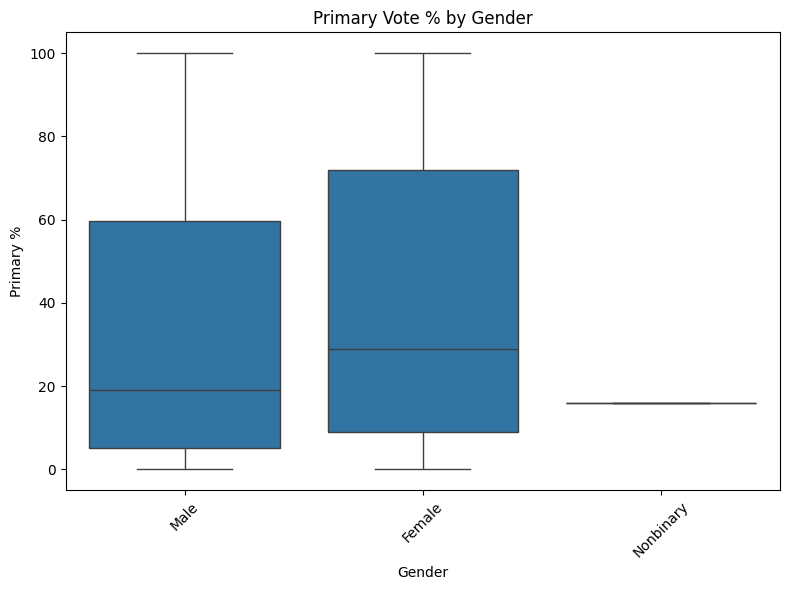

In [157]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Gender', y='Primary_%')
plt.title('Primary Vote % by Gender')
plt.ylabel('Primary %')
plt.xlabel('Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

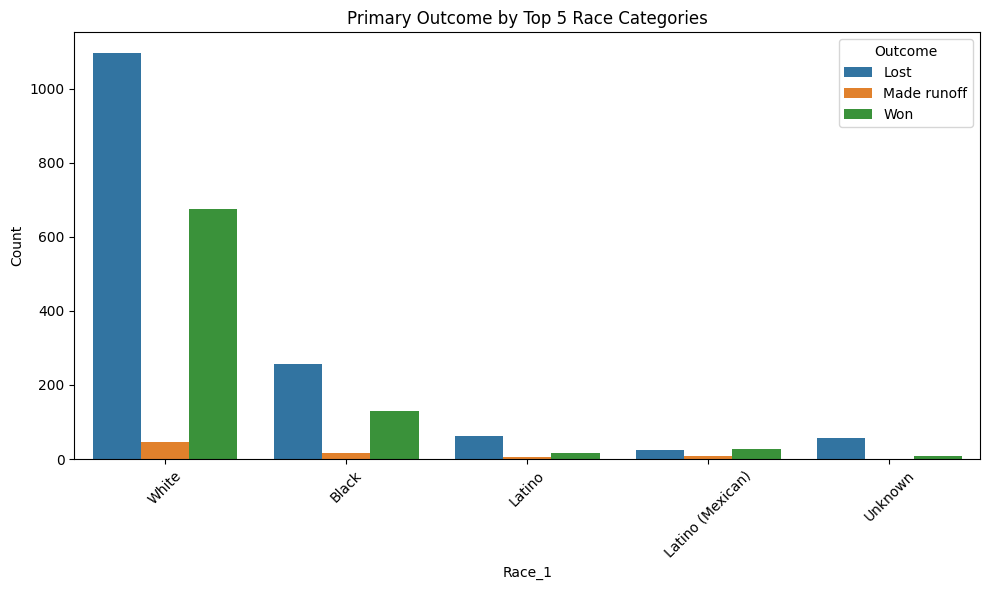

In [158]:
race_counts = df["Race_1"].value_counts()

# Pick the top N races (e.g., top 5)
top_races = race_counts.head(5).index

# Filter DataFrame to only those races
df_top = df[df["Race_1"].isin(top_races)]

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_top, x="Race_1", hue="Primary_Outcome")

plt.title("Primary Outcome by Top 5 Race Categories")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

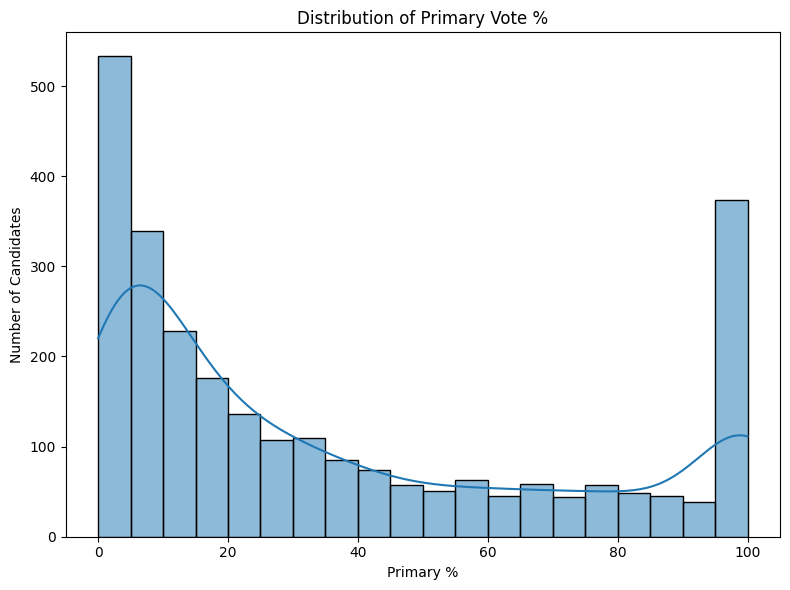

In [159]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Primary_%'].dropna(), kde=True, bins=20)
plt.title('Distribution of Primary Vote %')
plt.xlabel('Primary %')
plt.ylabel('Number of Candidates')
plt.tight_layout()
plt.show()

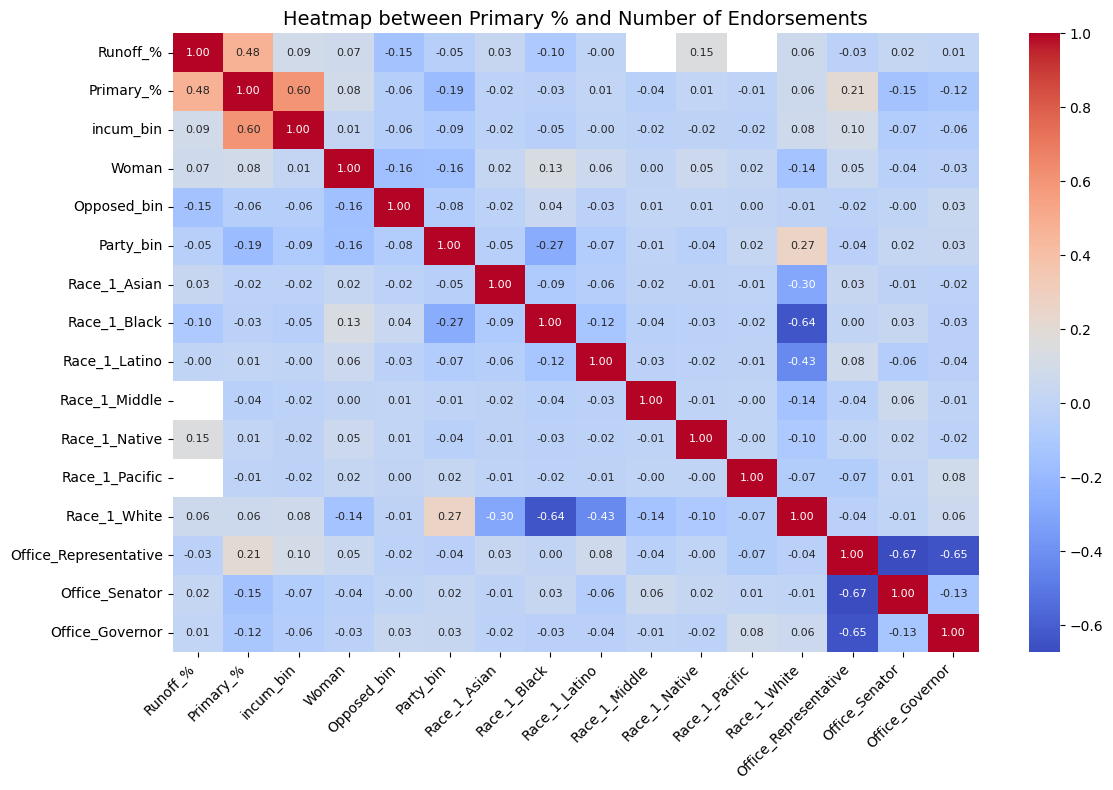

In [160]:
plt.figure(figsize=(12, 8))  # make the heatmap bigger
sns.heatmap(
    df[[
        "Runoff_%", "Primary_%", "incum_bin", "Woman", "Opposed_bin", "Party_bin",
        "Race_1_Asian", "Race_1_Black", "Race_1_Latino", "Race_1_Middle", 
        "Race_1_Native", "Race_1_Pacific", "Race_1_White", 
        "Office_Representative", "Office_Senator", "Office_Governor"
    ]].corr(),
    annot=True,
    fmt=".2f",        # 2 decimal places
    cmap="coolwarm",  # color scheme
    annot_kws={"size": 8}  # smaller text for annotations
)

plt.title("Heatmap between Primary % and Number of Endorsements", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)  # rotate x labels
plt.yticks(fontsize=10)
plt.tight_layout()  # avoid cutoff
plt.show()

## RQ 1

## RQ1: Statistical Testing

We test whether specific candidate characteristics are associated with higher vote share:

- Gender (t-test)  
- Race (ANOVA)  
- Incumbency (t-test)  
- Party (t-test)  
- Bernie Sanders endorsement (t-test)  
- EMILY’s List endorsement (t-test)  

Because multiple tests are run, we apply **Bonferroni** and **Benjamini–Hochberg (FDR)** corrections to control for error.  


In [161]:
df['Sanders_Endorsed']

0       False
1       False
2       False
3       False
4       False
        ...  
2671    False
2672    False
2673    False
2674    False
2675    False
Name: Sanders_Endorsed, Length: 2676, dtype: bool

In [162]:
from statsmodels.stats.power import TTestIndPower

_power_df = df[df['Primary_%'].notna()].copy()

if 'Sanders_Endorsed' not in _power_df.columns:
    _power_df['Sanders_Endorsed'] = _power_df['Sanders'].notna()

n_endorsed = _power_df['Sanders_Endorsed'].sum()
n_not_endorsed = len(_power_df) - n_endorsed
ratio = n_not_endorsed / n_endorsed

analysis = TTestIndPower()
power = analysis.power(effect_size=0.5, nobs1=n_endorsed, ratio=ratio, alpha=0.05)

print(f"Endorsed: {n_endorsed}, Not Endorsed: {n_not_endorsed}")
print(f"Estimated Power: {power:.2%}")

Endorsed: 102, Not Endorsed: 2566
Estimated Power: 99.86%


In [163]:
t1 = ttest_ind(
    df[df['Sanders_Endorsed']]['Primary_%'],
    df[~df['Sanders_Endorsed']]['Primary_%'],
    nan_policy='omit',
    equal_var=False
)

In [90]:
t2 = ttest_ind(
    df[df['Incumbent']]['Primary_%'],
    df[~df['Incumbent']]['Primary_%'],
    nan_policy='omit',
    equal_var=False
)

In [91]:
t3 = ttest_ind(
    df[df['Woman']]['Primary_%'],
    df[~df['Woman']]['Primary_%'],
    nan_policy='omit',
    equal_var=False
)

In [92]:
print(df['EMILYs_List_Endorsed'].value_counts())
print(df.groupby('EMILYs_List_Endorsed')['Primary_%'].count())

EMILYs_List_Endorsed
True    2676
Name: count, dtype: int64
EMILYs_List_Endorsed
True    2668
Name: Primary_%, dtype: int64


In [93]:
race_groups = [g['Primary_%'].dropna() for _, g in df.groupby('Race_1') if len(g) > 1]
t5 = f_oneway(*race_groups)

In [94]:
t6 = ttest_ind(
    df[df['Party'] == 'Democrat']['Primary_%'],
    df[df['Party'] == 'Republican']['Primary_%'],
    nan_policy='omit',
    equal_var=False
)

In [95]:
p_values = [t1.pvalue, t2.pvalue, t3.pvalue, t5.pvalue, t6.pvalue]
test_labels = [
    "Sanders Endorsement vs. Vote %",
    "Incumbent vs. Vote %",
    "Gender vs. Vote %",
    "Race vs. Vote %",
    "Party (D vs. R) vs. Vote %"
]

bonf = multipletests(p_values, method='bonferroni')
fdr = multipletests(p_values, method='fdr_bh')

results_df = pd.DataFrame({
    'Test': test_labels,
    'Raw p-value': p_values,
    'Bonferroni Adj p': bonf[1],
    'FDR Adj p': fdr[1],
    'Significant (Bonf)': bonf[0],
    'Significant (FDR)': fdr[0]
})

results_df

,Test,Raw p-value,Bonferroni Adj p,FDR Adj p,Significant (Bonf),Significant (FDR)
0,Sanders Endorsement vs. Vote %,1.898396e-10,9.491982e-10,3.163994e-10,True,True
1,Incumbent vs. Vote %,3.882655e-275,1.941327e-274,1.941327e-274,True,True
2,Gender vs. Vote %,1.483367e-05,7.416834e-05,1.854209e-05,True,True
3,Race vs. Vote %,2.032111e-04,1.016056e-03,2.032111e-04,True,True
4,Party (D vs. R) vs. Vote %,1.036717e-20,5.183585e-20,2.591793e-20,True,True


## RQ2: Causal Inference

Here, we estimate whether endorsements *cause* higher vote shares.  
We use **Inverse Propensity Weighting (IPW)** with logistic regression to adjust for confounders: incumbency, gender, opposition, party, race, and office.  

### Key Steps:
1. Estimate propensity scores (probability of being endorsed given covariates).  
2. Trim extreme scores (<0.1, >0.9) to reduce bias.  
3. Apply IPW to balance treatment and control groups.  
4. Estimate treatment effect on vote share.  

### Results

- **Naive ATE:** +38.2 percentage points  
- **Adjusted ATE (IPW):** +25.05 percentage points  
- **95% CI:** [14.88, 36.47]  

**Interpretation:** Endorsements have a substantial positive effect on candidate performance, even after controlling for observable confounders.  


In [96]:
confounders = ['incum_bin', 'Woman', 'Opposed_bin', 'Party_bin',
     "Race_1_Asian", "Race_1_Black", "Race_1_Latino", "Race_1_Middle", 
        "Race_1_Native", "Race_1_Pacific", "Race_1_White", 
        "Office_Representative", "Office_Senator", "Office_Governor"]

In [97]:
def estimate_treatment_effect(lr, X, Y, Z):
    ex = lr.predict_proba(X)[:, 1]
    return np.mean(Z * Y / ex) - np.mean((1 - Z) * Y / (1 - ex))

In [98]:
def get_confidence_interval(data, X, Y, Z):
    n_boots = 1000
    boots_ate = []
    for _ in range(n_boots):
        sample_df = resample(data)

        X_sample = sample_df[X.columns]
        Y_sample = sample_df[Y.name]
        Z_sample = sample_df['treated']

        model = LogisticRegression()
        model.fit(X_sample, Z_sample)

        boots_ate.append(estimate_treatment_effect(model, X_sample, Y_sample, Z_sample))

    bootstrap_ate = np.array(boots_ate)
    lower_bound = np.percentile(bootstrap_ate, 2.5)
    upper_bound = np.percentile(bootstrap_ate, 97.5)

    print("The 95% confidence interval for the ATE is: [{}, {}]".format(lower_bound, upper_bound))
    return bootstrap_ate, lower_bound, upper_bound

In [99]:
from sklearn.linear_model import LogisticRegression

# Inverse Probability Weighting

lr = LogisticRegression()
Z = df['treated']
X = df[confounders]
Y = df['Primary_%']
lr.fit(X, Z)
pscores = lr.predict_proba(X)[:, 1]


# Trimming the dataset based on pscores between 0.1 and 0.7
df['pscores'] = pscores
df_trimmed = df[(df['pscores'] > 0.10) & (df['pscores'] < 0.70)].copy()



X_trimmed = df_trimmed[confounders]
Z_trimmed = df_trimmed['treated']
Y_trimmed = df_trimmed['Primary_%']

lr_trimmed = LogisticRegression()
t_trimmed = df_trimmed['treated']
lr_trimmed.fit(X_trimmed, Z_trimmed)
pscores_trimmed = lr_trimmed.predict_proba(X_trimmed)[:, 1]

df_trimmed['pscores'] = pscores_trimmed
df_trimmed = df[(df['pscores'] > 0.10) & (df['pscores'] < 0.70)]


In [100]:

treated_mean = df[df['treated'] == 1]['Primary_%'].mean()
contol_mean = df[df['treated'] == 0]['Primary_%'].mean()

Naive_ATE = treated_mean - contol_mean
print(f"Naive ATE: {Naive_ATE}")


Naive ATE: 38.50377795671537


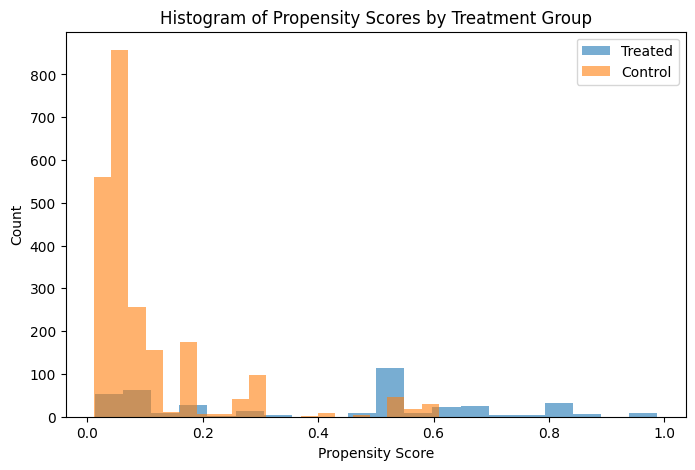

In [101]:
import matplotlib.pyplot as plt

# Pscores untrimmed dataset
plt.figure(figsize=(8, 5))
plt.hist(df[df["treated"] == 1]["pscores"], bins=20, alpha=0.6, label="Treated")
plt.hist(df[df["treated"] == 0]["pscores"], bins=20, alpha=0.6, label="Control")
plt.xlabel("Propensity Score")
plt.ylabel("Count")
plt.title("Histogram of Propensity Scores by Treatment Group")
plt.legend()
plt.show()


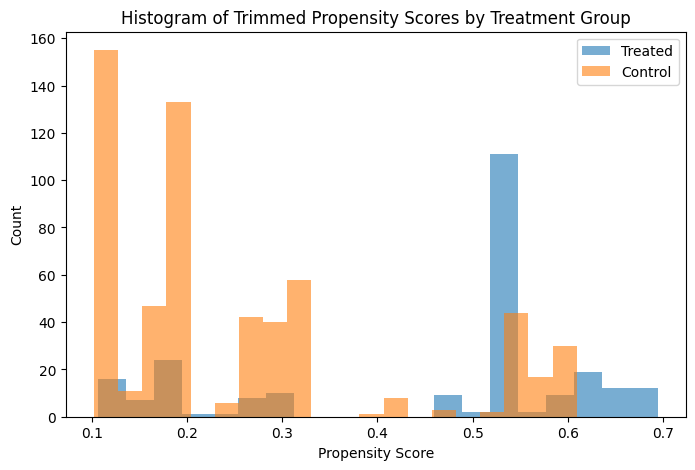

In [102]:
# Pscores trimmed dataset

plt.figure(figsize=(8, 5))
plt.hist(df_trimmed[df_trimmed["treated"] == 1]["pscores"], bins=20, alpha=0.6, label="Treated")
plt.hist(df_trimmed[df_trimmed["treated"] == 0]["pscores"], bins=20, alpha=0.6, label="Control")
plt.xlabel("Propensity Score")
plt.ylabel("Count")
plt.title("Histogram of Trimmed Propensity Scores by Treatment Group")
plt.legend()
plt.show()

/var/folders/8_/8p8vwl993bl8zs1xrcs95xlw0000gn/T/ipykernel_12030/2275899514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['weights'] = weights


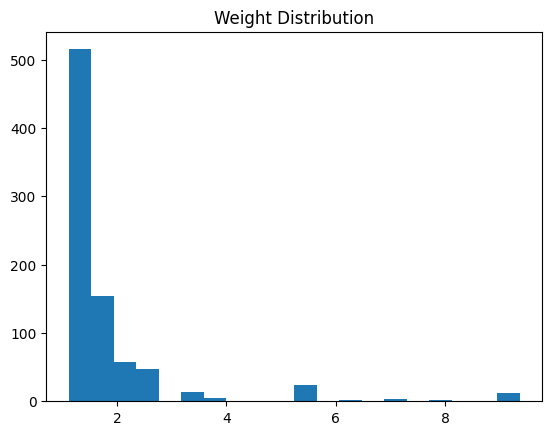

In [103]:
weights = Z_trimmed / df_trimmed['pscores'] + (1 - Z_trimmed) / (1 - df_trimmed['pscores'])
df_trimmed['weights'] = weights
plt.hist(weights, bins=20)
plt.title('Weight Distribution')
plt.show()

In [104]:
estimate = estimate_treatment_effect(lr_trimmed, X_trimmed, Y_trimmed, Z_trimmed)
print(f"Estimated ATE: {estimate}")

Estimated ATE: 25.489579870603905


In [105]:
def test_estimate(X, Y, Z):
    model = LogisticRegression()
    model.fit(X, Z)
    ehat = model.predict_proba(X)[: , 1]
    return np.mean(Z * Y / ehat) - np.mean((1 - Z) * Y / (1 - ehat))


wtf = test_estimate(X_trimmed, df_trimmed['Primary_%'], df_trimmed['treated'])
print(wtf)

25.489579870603905


In [106]:
point_estimate = estimate_treatment_effect(lr, X, Y, Z)
print(point_estimate)

32.19260636341699


In [107]:
estimates, lower_bound, upper_bound = get_confidence_interval(df_trimmed, X_trimmed, df_trimmed['Primary_%'], df_trimmed['treated'])

The 95% confidence interval for the ATE is: [15.49161055094951, 39.303816517244634]


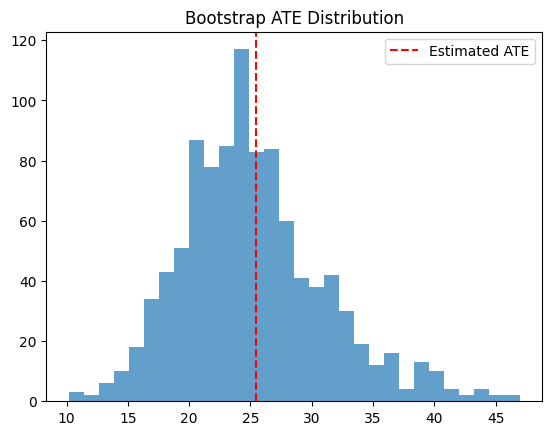

In [108]:
plt.hist(estimates, bins=30, alpha=0.7)
plt.axvline(estimate, color='red', linestyle='--', label='Estimated ATE')
plt.title("Bootstrap ATE Distribution")
plt.legend()
plt.show()

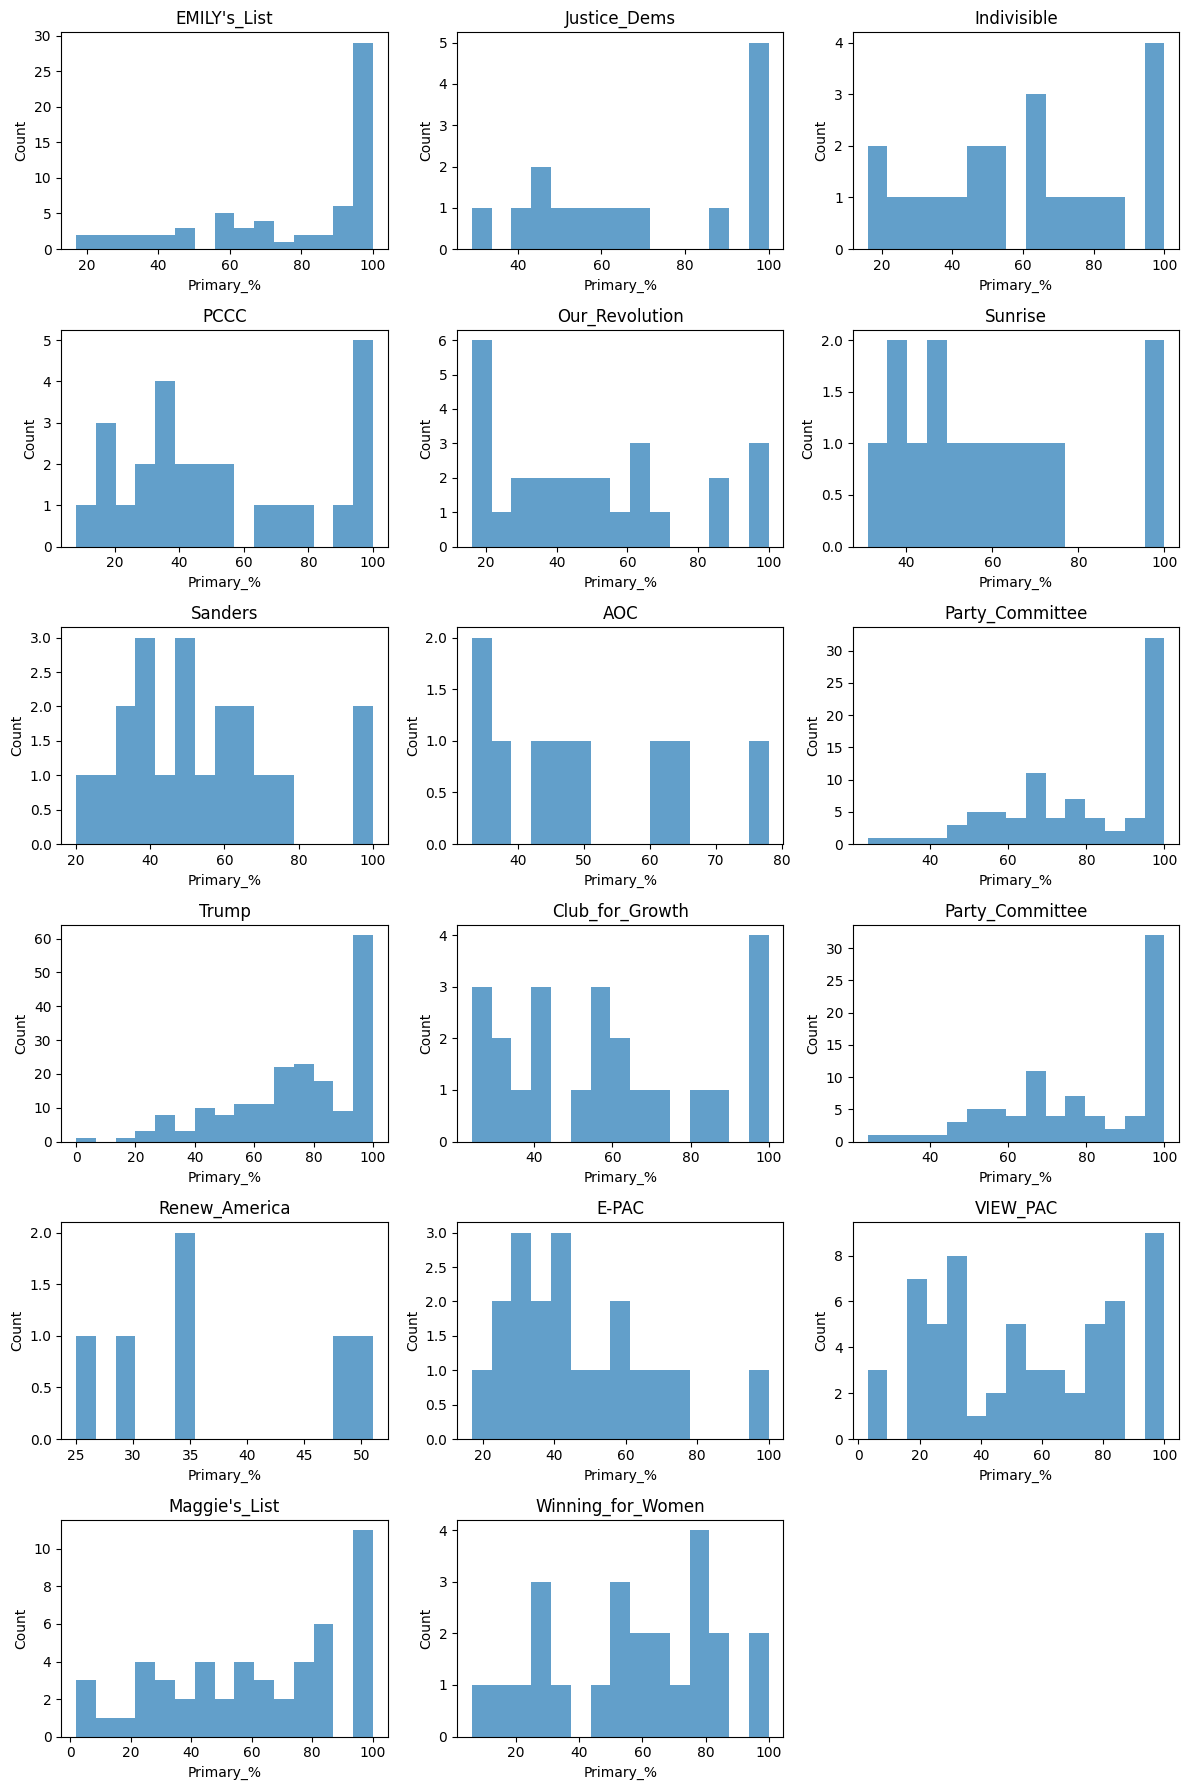

In [109]:
n = len(endorsements)
cols = 3  # columns in subplot grid
rows = (n + cols - 1) // cols  # compute needed rows

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))  # adjust size per panel
axes = axes.flatten()  # make it indexable like a 1D array

for i, endorsement in enumerate(endorsements):
    a = df[df[endorsement] == 1]['Primary_%']
    axes[i].hist(a, bins=15, alpha=0.7)
    axes[i].set_title(endorsement)
    axes[i].set_xlabel("Primary_%")
    axes[i].set_ylabel("Count")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

---

## Results & Conclusion

- **RQ1 (Statistical Testing):** Candidate traits such as incumbency, party, and Sanders endorsements are strongly associated with higher vote share.  
- **RQ2 (Causal Inference):** Receiving at least one endorsement *causes* an increase of ~25 percentage points in vote share (95% CI: 14.88–36.47).  

### Takeaways:
- Endorsements matter — but so do candidate traits like incumbency and race.  
- Observed associations (RQ1) should not be mistaken for causal effects (RQ2).  
- Our causal model suggests endorsements play a real, measurable role in primary outcomes.  

### Limitations & Next Steps:
- We assume all endorsements are equal; future work could separate high-profile vs. low-profile endorsements.  
- Adding campaign finance or district competitiveness data could improve causal estimates.  
- Comparing multiple election years would test the robustness of these findings.  
